# Импорт библиотек

In [92]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Загрузка данных и первичный обработка

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [29]:
df_train.isna().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
day                 0
month               0
weekend             0
days_delta          0
dtype: int64

In [30]:
df_test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
day                   0
month                 0
weekend               0
days_delta            0
dtype: int64

Пропуски данных встречаются только в столбце 'education'

<AxesSubplot:>

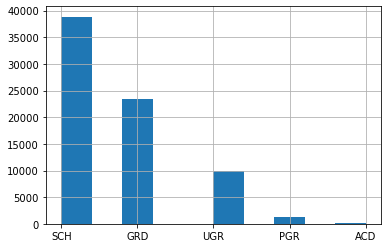

In [5]:
df_train['education'].hist()

Заполним пропуски в графе "образование" на самое часто встречающееся значение (моду) "SCH"

In [31]:
df_train['education'].fillna('SCH', inplace=True)
df_test['education'].fillna('SCH', inplace=True)
df_train.isna().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
day                 0
month               0
weekend             0
days_delta          0
dtype: int64

In [7]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


# Разведывательный анализ

Для EDA применим pandas-profiling

In [8]:
pdp.ProfileReport(df_train)

D:\Python\Anaconda\envs\new-env\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,19
Number of observations,73799
Total Missing (%),0.0%
Total size in memory,10.7 MiB
Average record size in memory,152.0 B
Numeric,11
Categorical,6
Boolean,2
Date,0
Text (Unique),0
Rejected,0


## app_date 

In [9]:
df_train['app_date'] = df_train['app_date'].apply(pd.to_datetime)
df_test['app_date'] = df_test['app_date'].apply(pd.to_datetime)
df_train['app_date'].dt.year.unique()

array([2014], dtype=int64)

Все заявки в датасэте собраны в один год (2014), для обучения эта информация не годится.
Вытащим данные о дне, месяце, дне недели, выходных, времени года, днях с начала года.

In [10]:
df_train['day'] = df_train['app_date'].dt.day
df_train['month'] = df_train['app_date'].dt.month
df_train['weekday'] = df_train['app_date'].dt.weekday
df_train['weekend'] = df_train['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
df_train['season'] = df_train['month'].apply(lambda x: 0 if x in [1, 2, 12] else (
                                           1 if x in [3, 4, 5] else (
                                           2 if x in [6, 7, 8] else 3)))
date = pd.to_datetime('01-01-2014')
df_train['days_delta'] = (df_train['app_date'] - date).dt.days

In [11]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,day,month,weekday,weekend,season,days_delta
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,4,1,N,0,1,2,5,1,0,31
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,4,1,N,0,12,3,2,0,1,70
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,1,4,Y,0,1,2,5,1,0,31
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,...,1,3,N,0,23,1,3,0,0,22
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,...,1,4,Y,0,18,4,4,0,1,107


<AxesSubplot:>

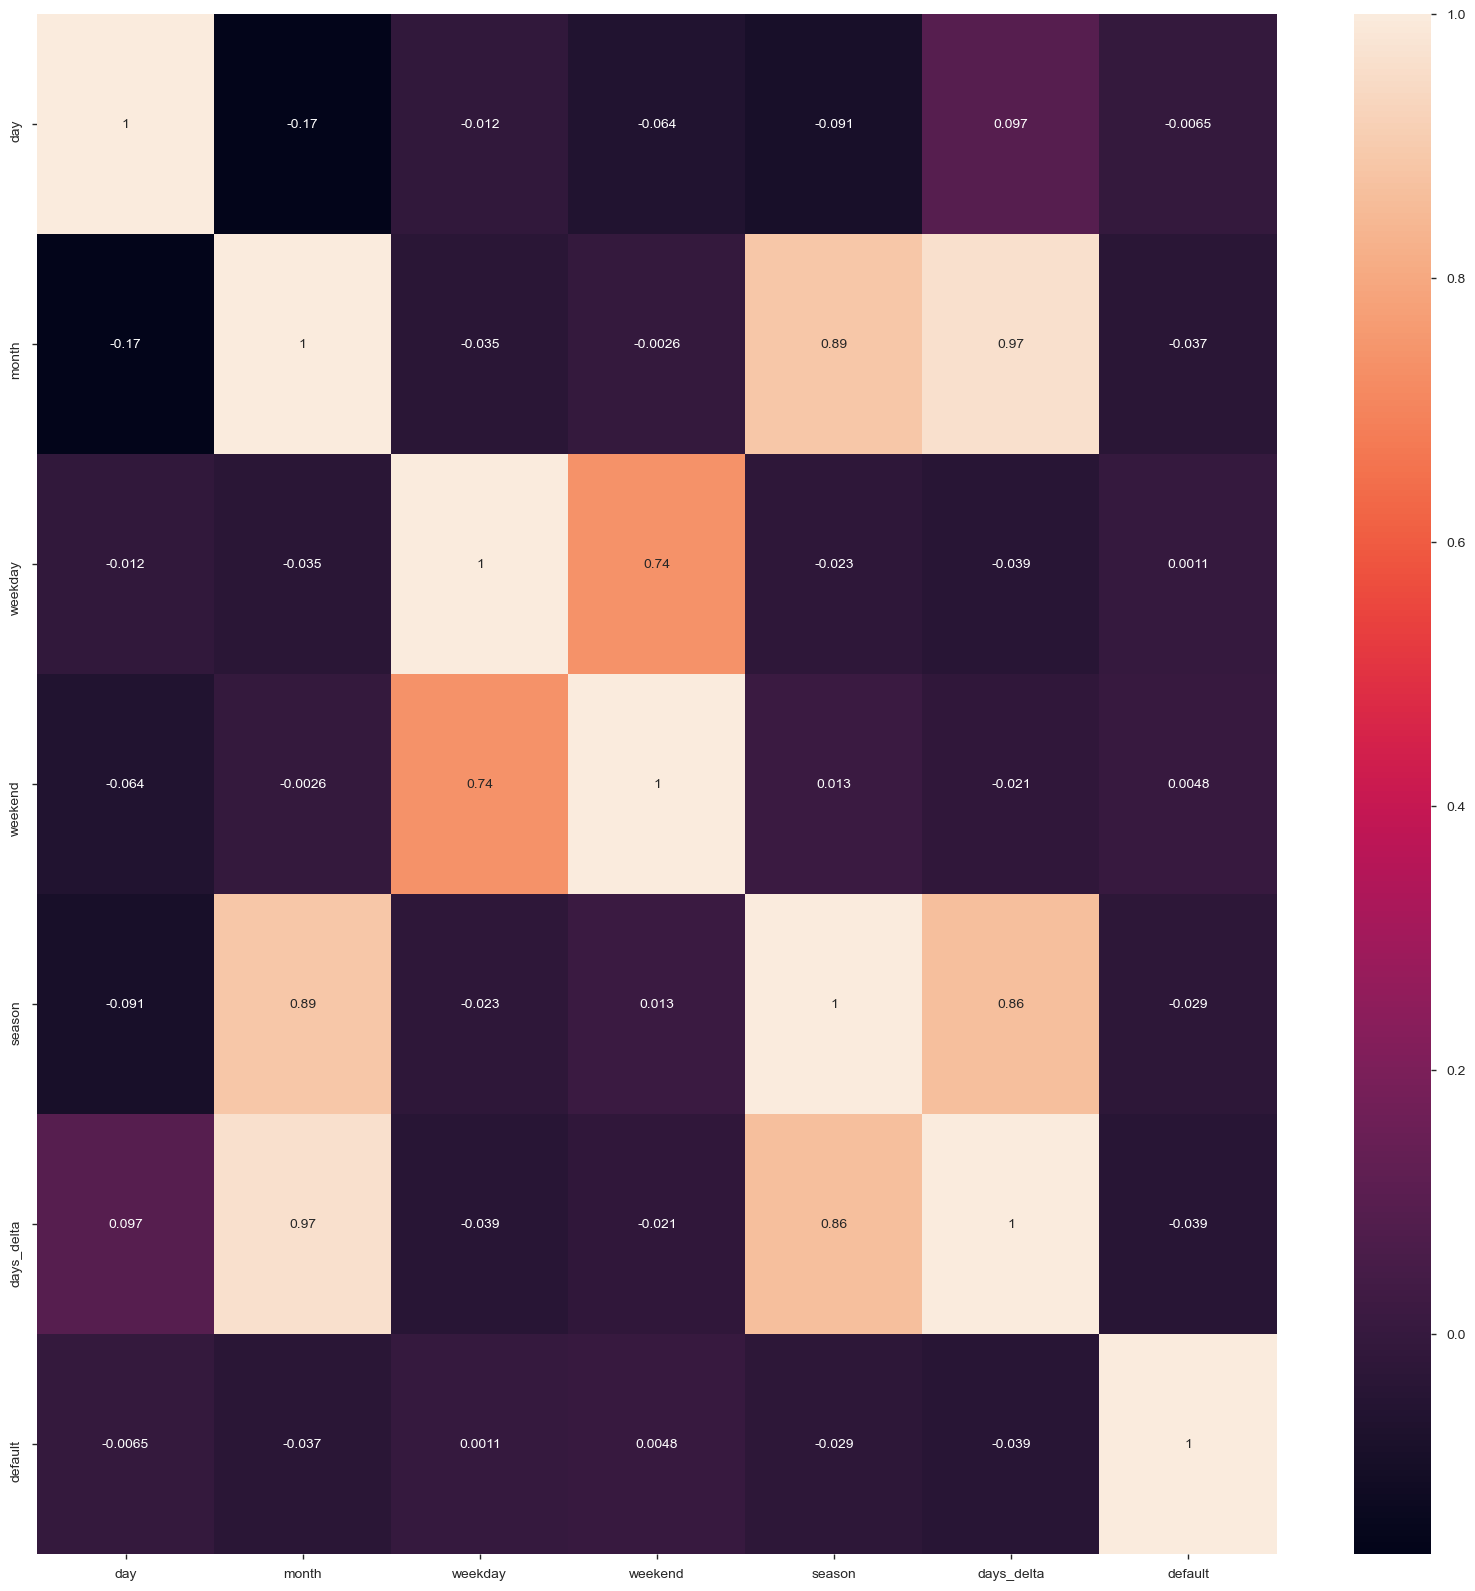

In [12]:
# Проверим корреляцию новых параметров
C = df_train[['day', 'month', 'weekday', 'weekend', 'season', 'days_delta', 'default']].corr(method='pearson')
plt.figure(figsize = (20, 20)) # размер графика
sns.heatmap(data = C, annot = True)

Новые параметры слабо скоррелированы с целевой переменной.
'weekday'  и 'weekend' сильно скоррелированы между собой -> оставим бинарный 'weekend'.
'season' и 'days_delta' сильно скоррелированы между собой -> оставляем 'days_delta'.
Самая высокая корреляция с целевой переменной у параметра 'month' (-0,012) -> отсавляем.

In [13]:
df_train.drop(['weekday', 'season', 'app_date'], axis=1, inplace=True)
df_train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,day,month,weekend,days_delta
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0,1,2,1,31
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0,12,3,0,70
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0,1,2,1,31
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0,23,1,0,22
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0,18,4,0,107


Добавим новые параметры в тестовый набор данных

In [15]:
df_test['day'] = df_test['app_date'].dt.day
df_test['month'] = df_test['app_date'].dt.month
df_test['weekend'] = df_test['app_date'].apply(lambda x: 1 if x.weekday in [5, 6] else 0)
df_test['days_delta'] = (df_test['app_date'] - date).dt.days
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,day,month,weekend,days_delta
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,...,1,2,50000,1,4,N,22,3,0,80
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,...,1,2,5000,4,3,N,24,1,0,23
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,...,1,2,30000,1,3,Y,23,3,0,81
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,...,1,2,17000,1,3,N,3,2,0,33
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,...,2,3,120000,1,3,N,4,2,0,34


Когда все имеющиеся параметры обработаны, разделим их на группы.

In [63]:
# бинарные параметры
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
# категориальные параметры
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time']
# числовые параметры
num_cols = ['age', 'decline_app_cnt', 'income', 'score_bki', 'bki_request_cnt', 'day', 'month', 'days_delta']

# Бинарные парметры

In [17]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])
    
# убедимся в преобразовании    
df_train.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,day,month,weekend,days_delta
0,25905,SCH,1,62,1,1,0,0,-2.008753,1,...,2,18000,4,1,0,0,1,2,1,31
1,63161,SCH,0,59,0,0,0,0,-1.532276,3,...,3,19000,4,1,0,0,12,3,0,70
2,25887,SCH,1,25,1,0,2,0,-1.408142,1,...,2,30000,1,4,1,0,1,2,1,31


# Числовые параметры

## Значимость числовых переменных 

<AxesSubplot:>

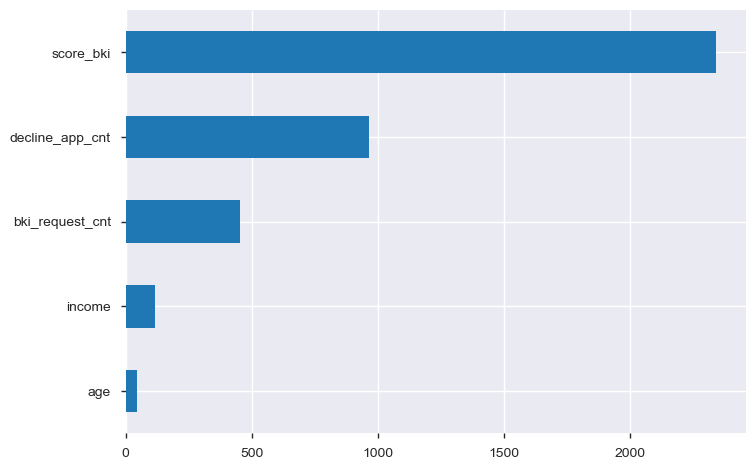

In [18]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## score_bki

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score_bki', ylabel='Density'>

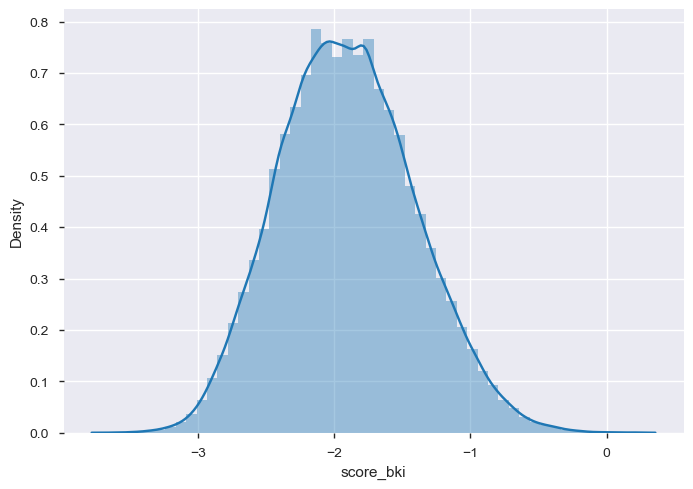

In [19]:
sns.distplot(df_train['score_bki'])

<AxesSubplot:>

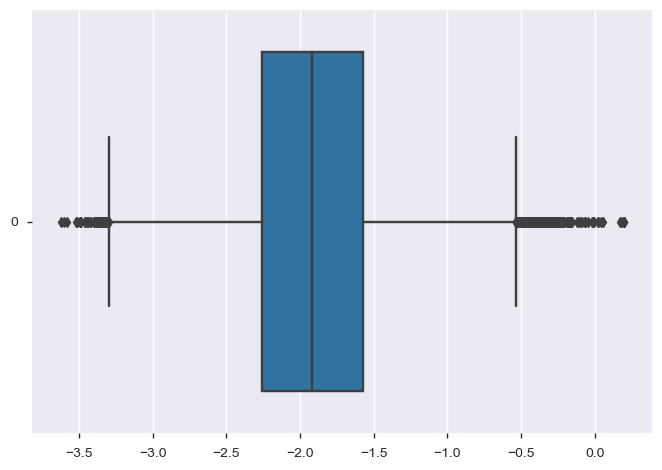

In [20]:
sns.boxplot(data=df_train['score_bki'], orient='h')

In [21]:
df_train['score_bki'].describe()

count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64

Распределение выглядит нормальным, попробуем избавиться от выбросов, в последствии применим StandardScaler

In [22]:
# Функция принимает pandas.Series, определяет межквартильный размах и возвращает два предельных значения
# Q1-1.5IQR и Q3+1.5IQR для последующего избавления от выбросов.

def value_limits(data):
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5*iqr
    upper_limit = q3 + 1.5*iqr
    return lower_limit, upper_limit

In [23]:
# Убираем выбросы из столбца

limits = value_limits(df_train['score_bki'])
df_train = df_train.loc[df_train['score_bki'].between(limits[0], limits[1])]
df_train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,day,month,weekend,days_delta
0,25905,SCH,1,62,1,1,0,0,-2.008753,1,...,2,18000,4,1,0,0,1,2,1,31
1,63161,SCH,0,59,0,0,0,0,-1.532276,3,...,3,19000,4,1,0,0,12,3,0,70
2,25887,SCH,1,25,1,0,2,0,-1.408142,1,...,2,30000,1,4,1,0,1,2,1,31
3,16222,SCH,0,53,0,0,0,0,-2.057471,2,...,3,10000,1,3,0,0,23,1,0,22
4,101655,GRD,1,48,0,0,0,1,-1.244723,1,...,3,30000,1,4,1,0,18,4,0,107


<AxesSubplot:>

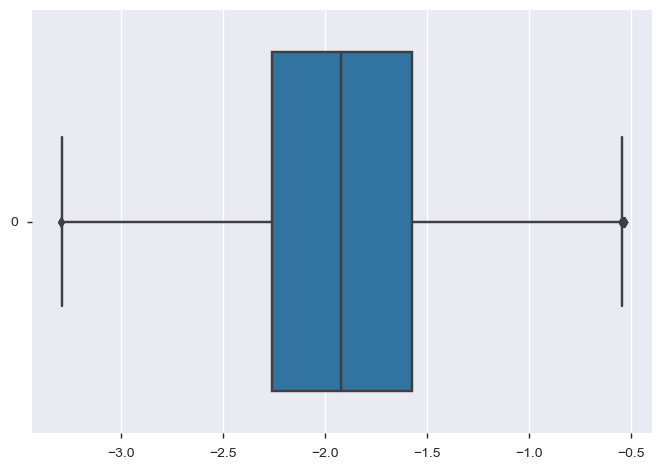

In [24]:
sns.boxplot(data=df_train['score_bki'], orient='h')

In [25]:
df_train['score_bki'].describe()

count    73448.000000
mean        -1.909904
std          0.488064
min         -3.294032
25%         -2.260161
50%         -1.922525
75%         -1.575116
max         -0.535839
Name: score_bki, dtype: float64

## decline_app_cnt

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='decline_app_cnt', ylabel='Density'>

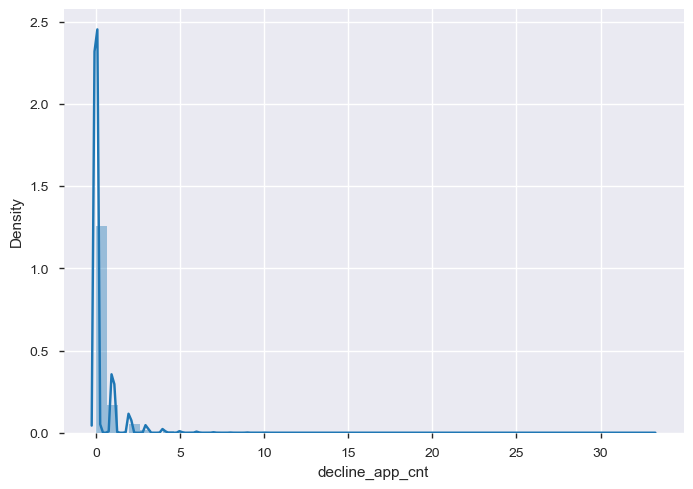

In [32]:
sns.distplot(df_train['decline_app_cnt'])

<AxesSubplot:>

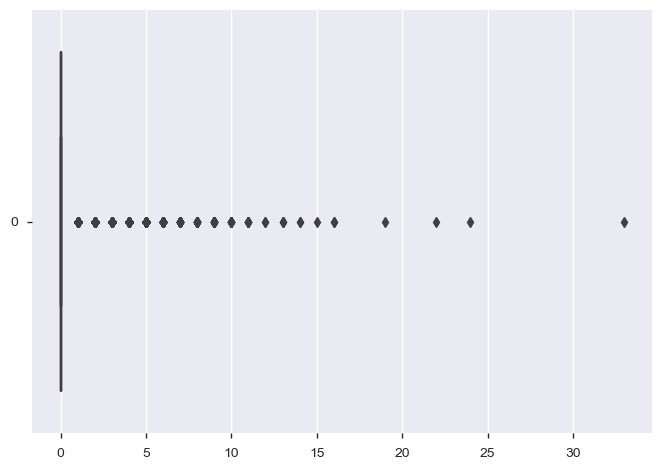

In [34]:
sns.boxplot(data=df_train['decline_app_cnt'], orient='h')

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

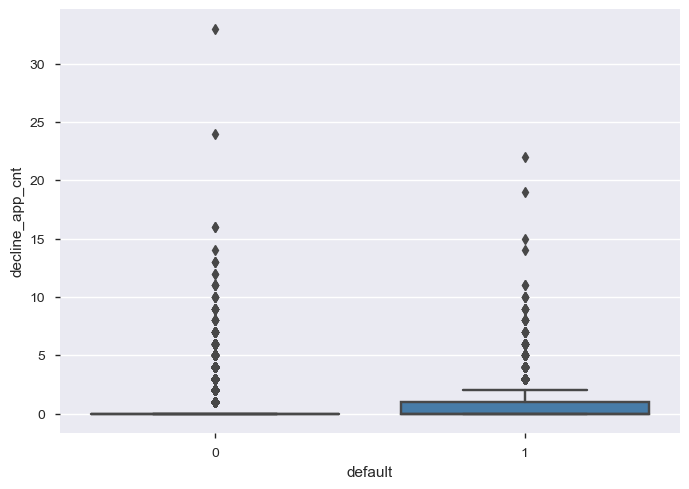

In [35]:
sns.boxplot(x="default", y="decline_app_cnt", data=df_train, palette='Set1')

Значительный всплесков значений параметра не обнаружено. Логарифмируем и в последствии стандартизируем параметр.

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

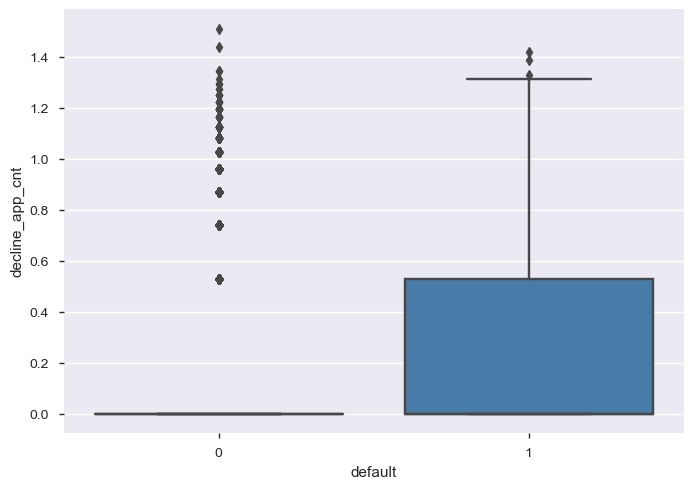

In [37]:
df_train['decline_app_cnt'] = df_train['decline_app_cnt'].apply(np.log1p)
df_test['decline_app_cnt'] = df_test['decline_app_cnt'].apply(np.log1p)
sns.boxplot(x="default", y="decline_app_cnt", data=df_train, palette='Set1')

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='decline_app_cnt', ylabel='Density'>

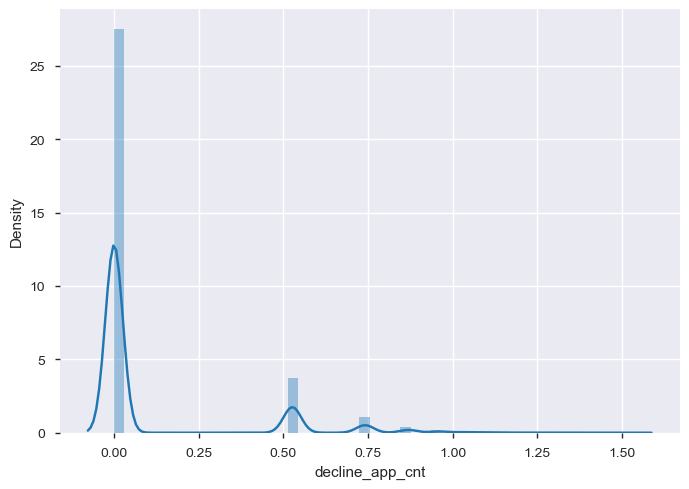

In [38]:
sns.distplot(df_train['decline_app_cnt'])

## bki_request_cnt

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bki_request_cnt', ylabel='Density'>

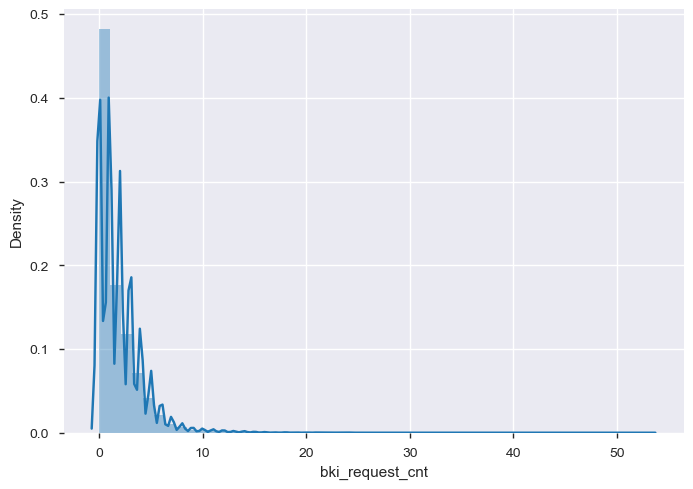

In [39]:
sns.distplot(df_train['bki_request_cnt'])

<AxesSubplot:>

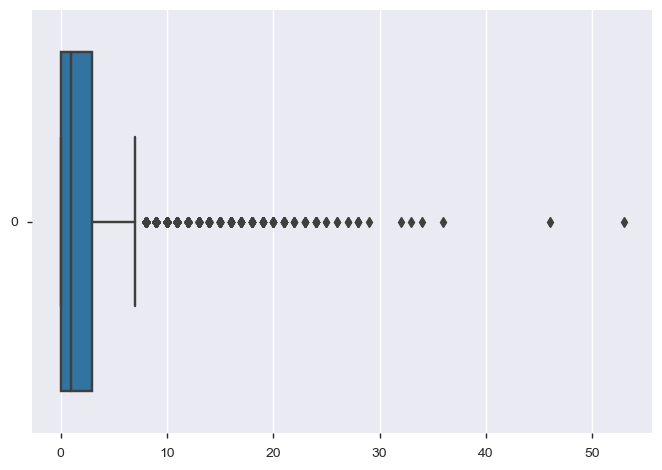

In [40]:
sns.boxplot(data=df_train['bki_request_cnt'], orient='h')

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

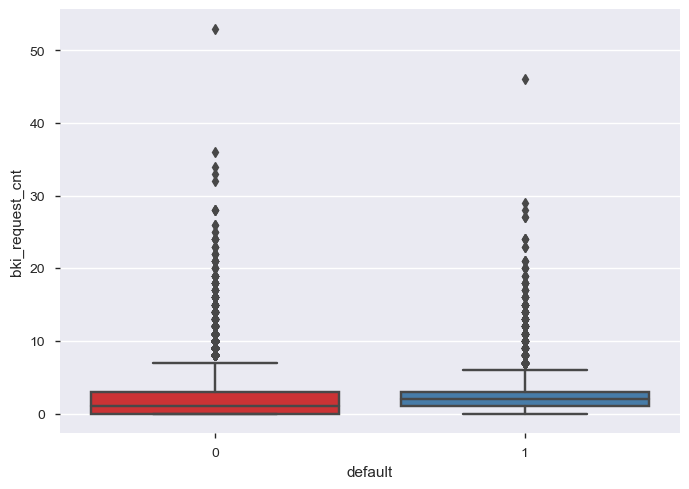

In [41]:
sns.boxplot(x="default", y="bki_request_cnt", data=df_train, palette='Set1')

Распределение значений параметра похоже на экспоненциальное. Уберем выбросы, логарифмируем, в дальнейшем стандартизируем.

In [43]:
# Убираем выбросы из столбца

limits = value_limits(df_train['bki_request_cnt'])
df_train = df_train.loc[df_train['bki_request_cnt'].between(limits[0], limits[1])]
df_train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,day,month,weekend,days_delta
0,25905,SCH,1,62,1,1,0.000000,0,-2.008753,1,...,2,18000,4,1,0,0,1,2,1,31
1,63161,SCH,0,59,0,0,0.000000,0,-1.532276,3,...,3,19000,4,1,0,0,12,3,0,70
2,25887,SCH,1,25,1,0,0.741276,0,-1.408142,1,...,2,30000,1,4,1,0,1,2,1,31
3,16222,SCH,0,53,0,0,0.000000,0,-2.057471,2,...,3,10000,1,3,0,0,23,1,0,22
4,101655,GRD,1,48,0,0,0.000000,1,-1.244723,1,...,3,30000,1,4,1,0,18,4,0,107


<AxesSubplot:>

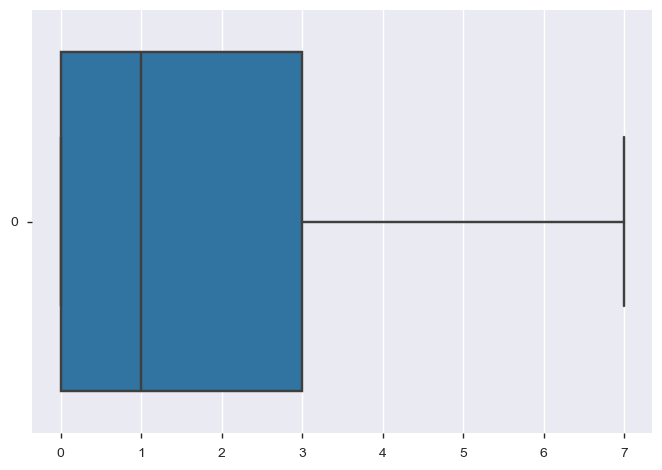

In [44]:
sns.boxplot(data=df_train['bki_request_cnt'], orient='h')

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

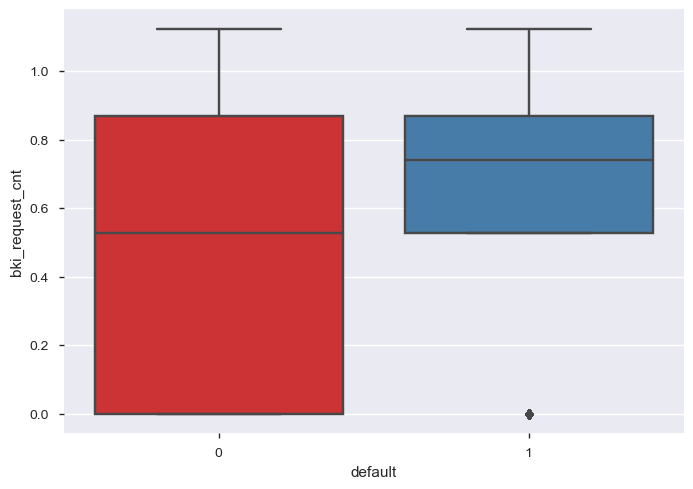

In [46]:
df_train['bki_request_cnt'] = df_train['bki_request_cnt'].apply(np.log1p)
df_test['bki_request_cnt'] = df_test['bki_request_cnt'].apply(np.log1p)
sns.boxplot(x="default", y="bki_request_cnt", data=df_train, palette='Set1')

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bki_request_cnt', ylabel='Density'>

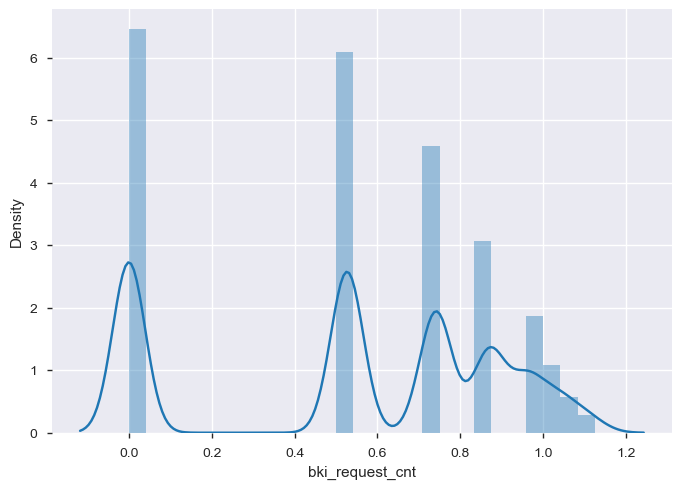

In [47]:
sns.distplot(df_train['bki_request_cnt'])

## income

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

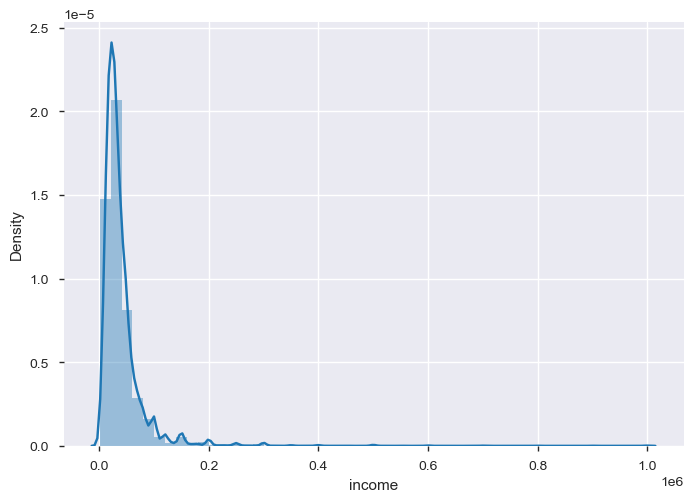

In [48]:
sns.distplot(df_train['income'])

<AxesSubplot:xlabel='default', ylabel='income'>

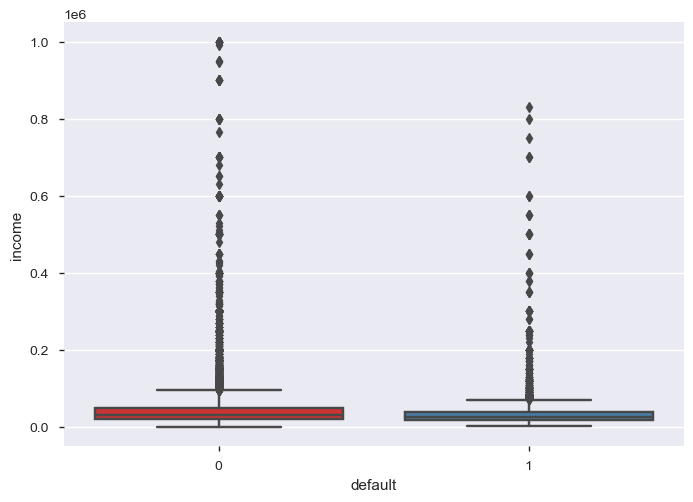

In [49]:
sns.boxplot(x="default", y="income", data=df_train, palette='Set1')

Распределение значений параметра похоже на экспоненциальное. Значительных выбросов значений нет, логарифмируем, в дальнейшем стандартизируем.

<AxesSubplot:xlabel='default', ylabel='income'>

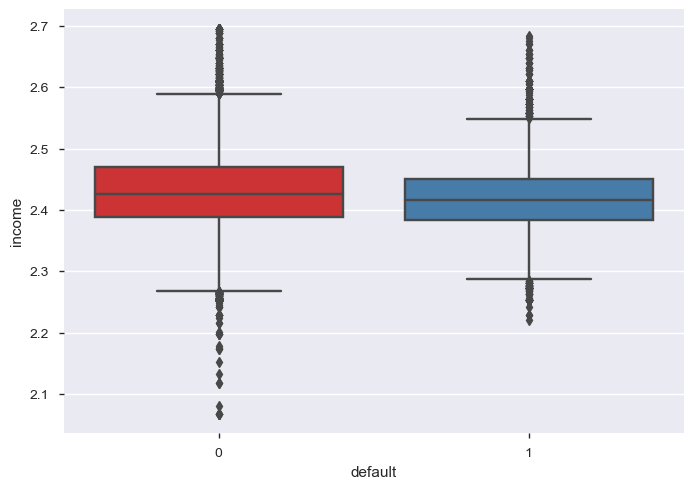

In [51]:
df_train['income'] = df_train['income'].apply(np.log1p)
df_test['income'] = df_test['income'].apply(np.log1p)
sns.boxplot(x="default", y="income", data=df_train, palette='Set1')

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

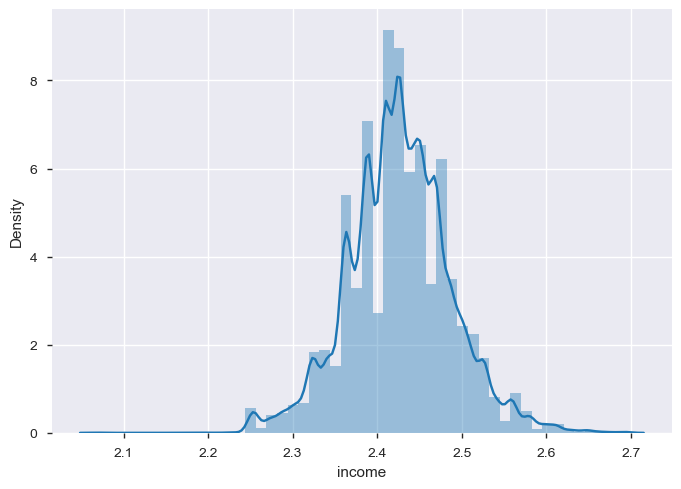

In [52]:
sns.distplot(df_train['income'])

## age

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

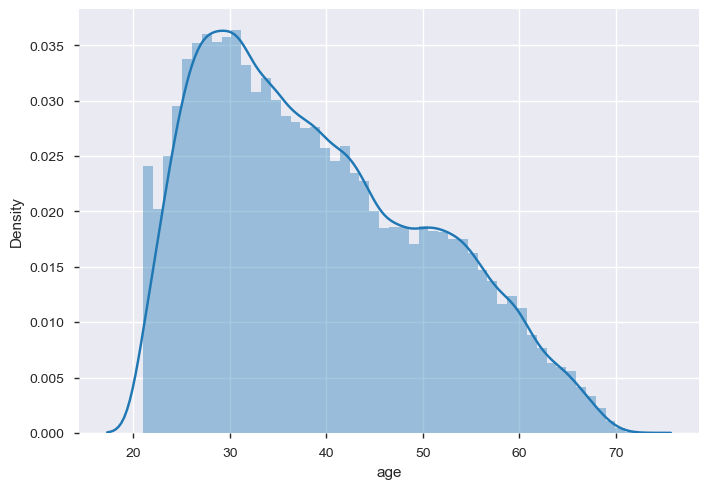

In [53]:
sns.distplot(df_train['age'])

<AxesSubplot:xlabel='default', ylabel='income'>

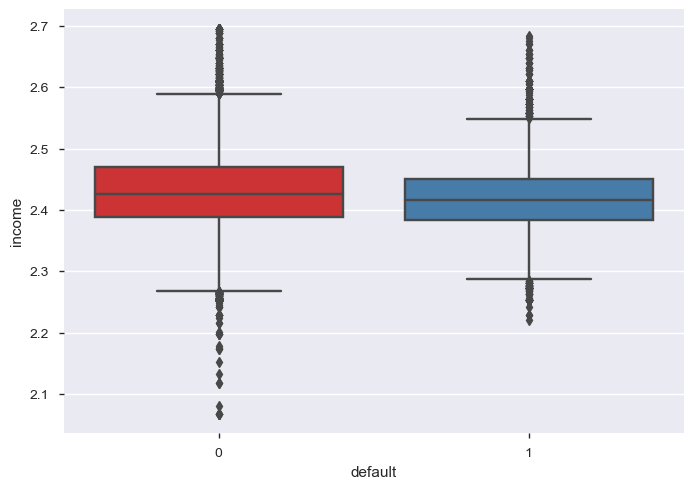

In [54]:
sns.boxplot(x="default", y="income", data=df_train, palette='Set1')

Значительных выбросов значений нет, логарифмируем, в дальнейшем стандартизируем.

<AxesSubplot:xlabel='default', ylabel='age'>

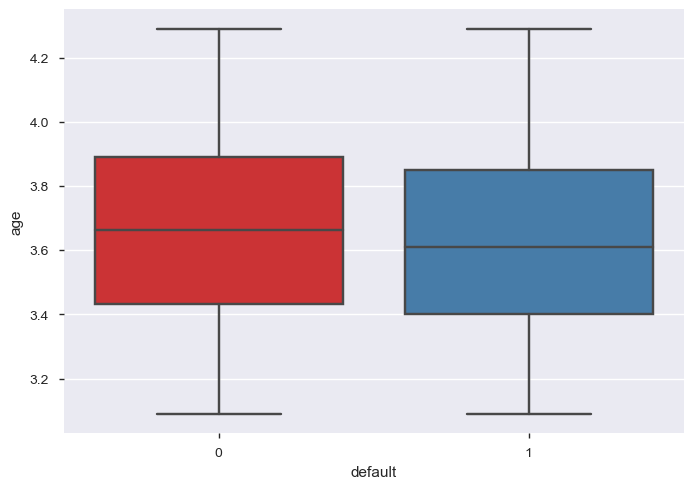

In [55]:
df_train['age'] = df_train['age'].apply(np.log1p)
df_test['age'] = df_test['age'].apply(np.log1p)
sns.boxplot(x="default", y="age", data=df_train, palette='Set1')

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

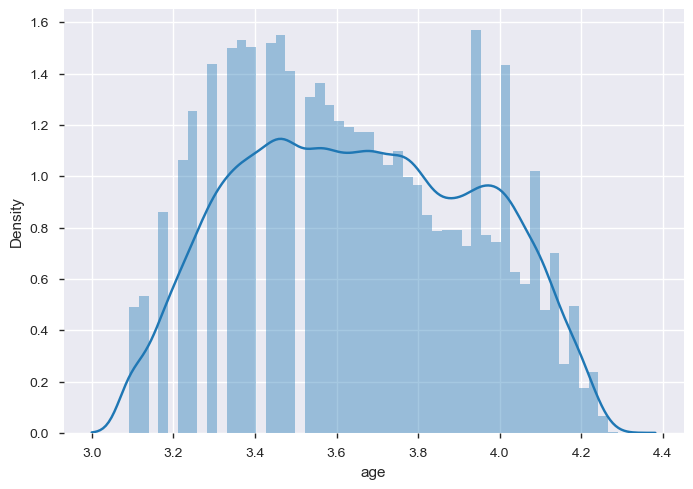

In [56]:
sns.distplot(df_train['age'])

# Корреляция числовых параметров

<AxesSubplot:>

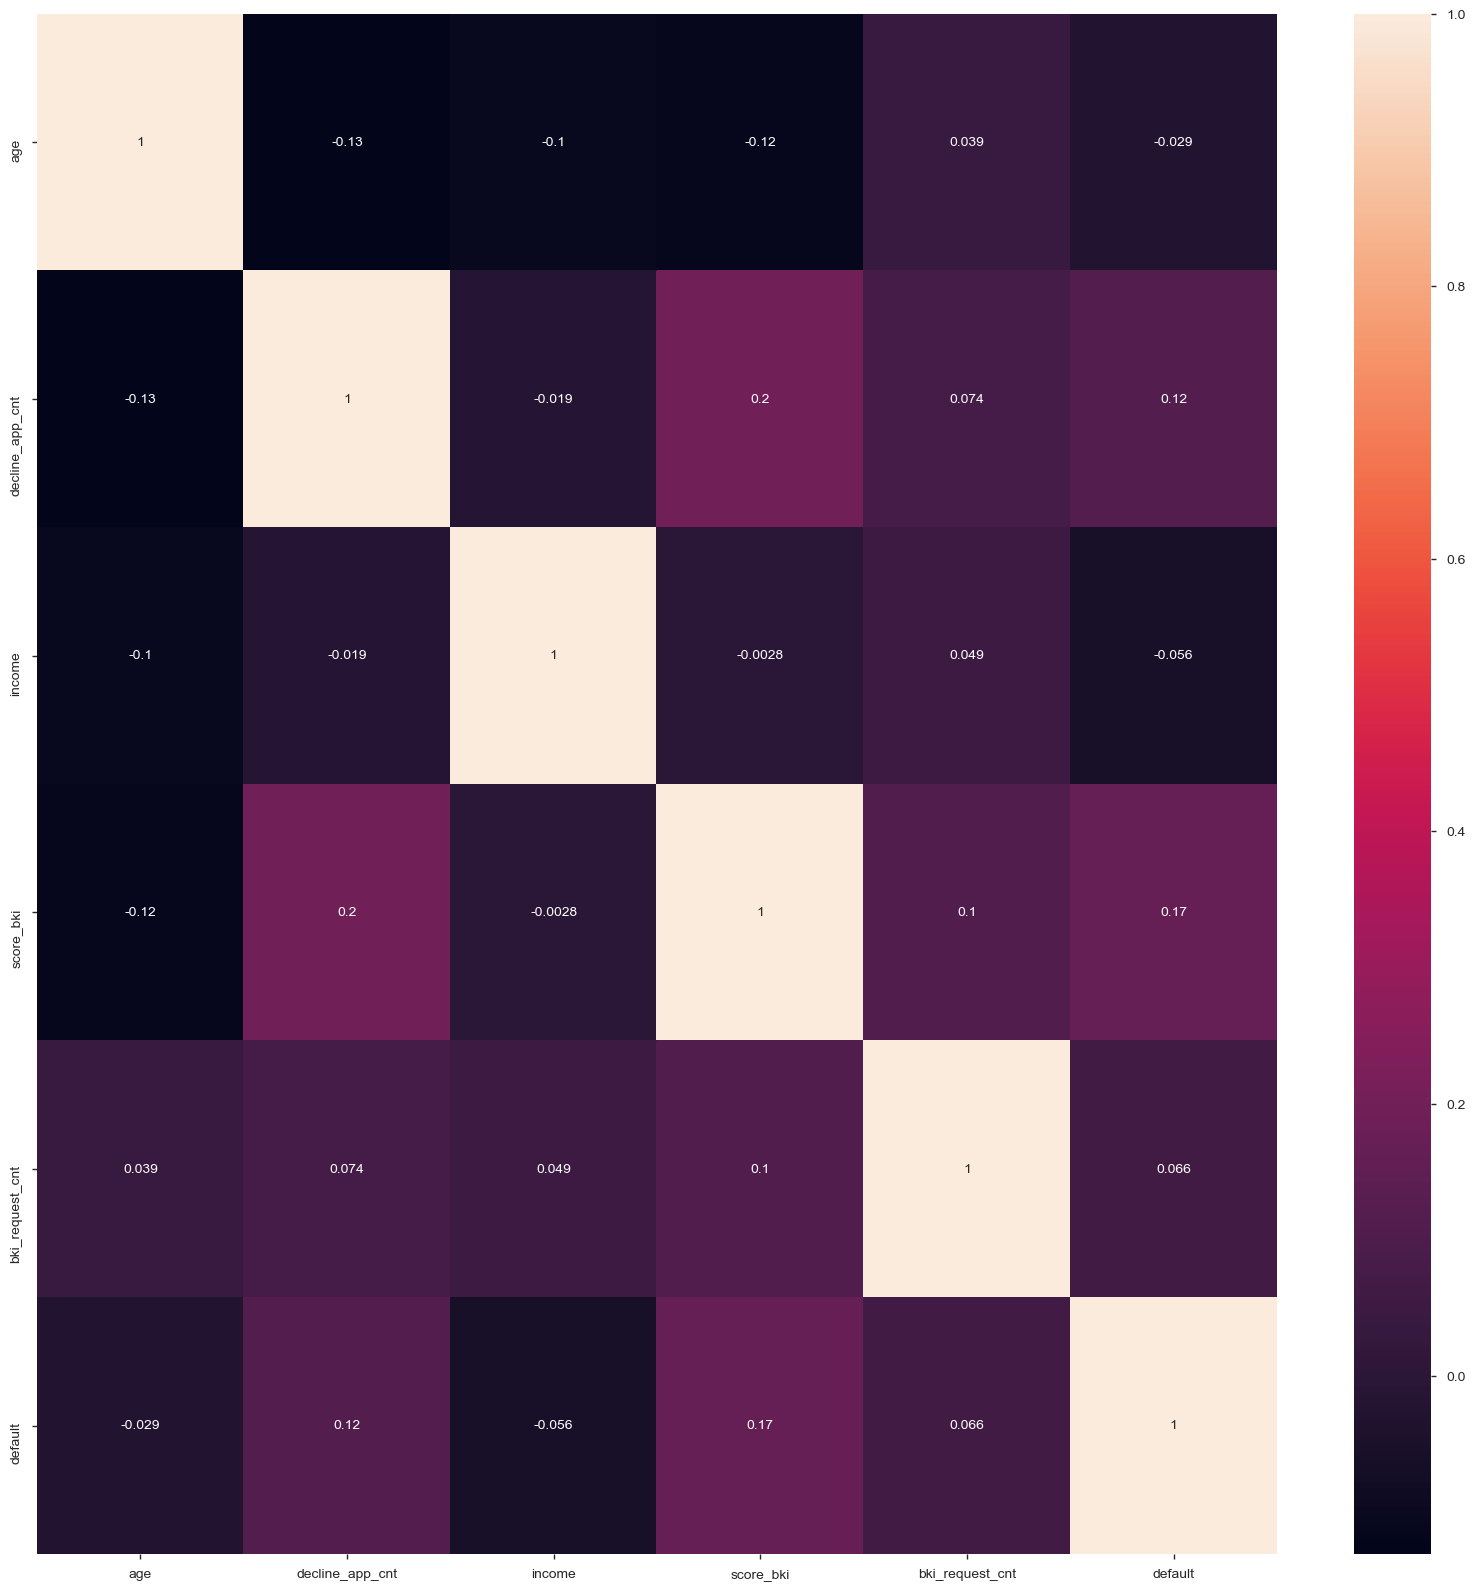

In [64]:
# Проверим корреляцию новых параметров
C = df_train[['age', 'decline_app_cnt', 'income', 'score_bki', 'bki_request_cnt', 'default']].corr(method='pearson')
plt.figure(figsize = (20, 20)) # размер графика
sns.heatmap(data = C, annot = True)

Высокой корреляции между параметрами нет.

# Категориальные параметры

In [76]:
df_train_cat = OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)
df_train_cat.shape

(134006, 26)

In [77]:
df_test_cat = OneHotEncoder(sparse = False).fit_transform(df_test[cat_cols].values)
df_test_cat.shape

(36349, 26)

# Целевая переменная

D:\Python\Anaconda\envs\new-env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='default', ylabel='count'>

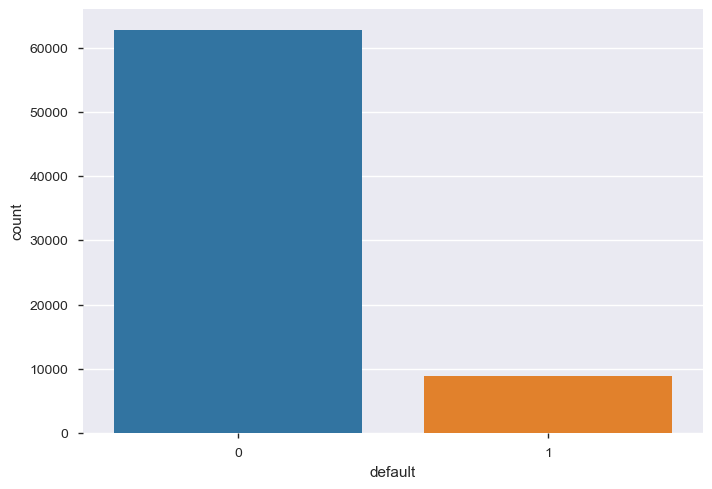

In [70]:
sns.countplot(df_train['default'])

Целевая еременная распределена довольно неравномерно, для устранения дисбаланса применим oversampling

In [72]:
df_train_0 = df_train.query('default == 0')
df_train_1 = df_train.query('default == 1')
k = int(len(df_train_0)/len(df_train_1))
for i in range(k):
    df_train = df_train.append(df_train_1).reset_index(drop=True)
df_train['default'].value_counts()

1    71160
0    62846
Name: default, dtype: int64

# Подготовка данных к машинному обучению

## Стандартизация числовых переменных

In [73]:
poly = PolynomialFeatures(2)

df_train_poly = poly.fit_transform(df_train[num_cols].values)
df_test_poly = poly.fit_transform(df_test[num_cols].values)

In [74]:
df_train_num = StandardScaler().fit_transform(df_train_poly)
df_test_num = StandardScaler().fit_transform(df_test_poly)
print(df_train_num.shape, df_test_num.shape)

(134006, 45) (36349, 45)


##  Объединяем подготовленные данные

In [79]:
X = np.hstack([df_train_num, df_train[bin_cols].values, df_train_cat])
Y = df_train['default'].values
print(X.shape, Y.shape)

(134006, 77) (134006,)


In [80]:
test_id = df_test['client_id']
test = np.hstack([df_test_num, df_test[bin_cols].values, df_test_cat])
print(test.shape, test_id.shape)

(36349, 77) (36349,)


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle=True)

# Гиперпараметры

In [82]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Python\Anaconda

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

Лучшее Penalty: l2
Лучшее C: 1291.5496650148827


D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Оценка качества модели

D:\Python\Anaconda\envs\new-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


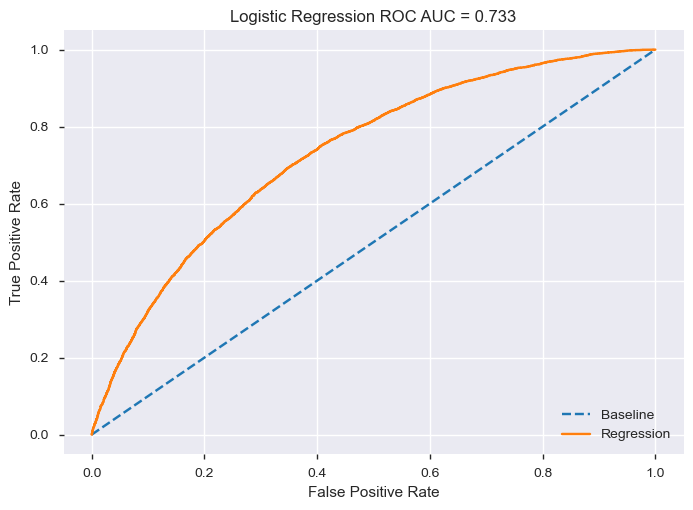

In [83]:
model = LogisticRegression(max_iter=1000, random_state=42, C=1291.5496650148827)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [91]:
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred):.3f}\tF1-score: {f1_score(y_test, y_pred):.3f}')

acc: 0.674	F1-score: 0.698


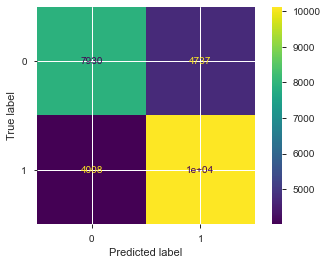

In [93]:
plot_confusion_matrix(model, X_test, y_test)

In [96]:
probs = model.predict_proba(test)
probs = probs[:, 1]
submission = pd.DataFrame({'client_id': test_id, 'default': probs})
submission.head()

,client_id,default
0,74835,0.249714
1,17527,0.842950
2,75683,0.377323
3,26883,0.480976
4,28862,0.182125


In [97]:
submission.to_csv('submission.csv', index=False)